In [6]:
!pip install pickle5

  Using cached pickle5-0.0.11-cp38-cp38-macosx_10_15_x86_64.whl


In [180]:
import sys
sys.path.insert(0, '../')
from registrationNN.models import model_visualizer
from utils.ObjectUtil import ObjectUtil
import numpy as np
from utils.RegistrationUtils import RegistrationUtils
from utils.ObjectUtil import ObjectUtil
import numpy as np
from lapjv import lapjv
from utils.RegistrationUtils import RegistrationUtils
from sketch_object.UnlabeledObject import UnlabeledObject
import copy
from sketch_object.Stroke import Stroke
from animator.SketchAnimation import SketchAnimation
import pickle5 as pickle
import os

from utils.Config import Config
from utils.ObjectUtil import ObjectUtil
from tools.FeedbackGenerator import VideoGenerator
from registrationNN.models import NNModel
import time
import matplotlib.pyplot as plt
from sketch_object.Point import Point

In [121]:
%load_ext autoreload

%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
model_tag = 'generative_video_exp1' # deep learning model to use for alignment
question_name = 'ReflectionQuestion'
org_sketch_id = '2_58c52b2b-94f4-49e1-b94c-d93964b1319c'
tar_sketch_id = '2_375abf06-c64a-46d8-8b65-e7e6c7f4e6d7'

config = Config.default_video_config(question_name, org_sketch_id, tar_sketch_id)
config.vis_video = True
config.load_trans_params = False
config.fine_tune_epochs = 500
config.verbose = 1

model_params = Config.default_model_config(model_tag)
model_params.load = False
model_params.load_ckpt = False
model_params.save = False
model_params.save_ckpt = False
model_params.learning_rate = 1e-2

In [183]:
# load original and target sketch 
org_sketch, org_labels = ObjectUtil.xml_to_UnlabeledObjects(config.org_sketch_path, 
                                                            mn_len=config.mn_len, 
                                                            re_sampling=config.re_sampling, 
                                                            flip=config.org_flip, 
                                                            shift_x=config.org_shift_x,
                                                             shift_y=config.org_shift_y)

tar_sketch, tar_labels = ObjectUtil.xml_to_UnlabeledObjects(config.tar_sketch_path, 
                                                            mn_len=config.mn_len, 
                                                            re_sampling=config.re_sampling, 
                                                            flip=config.tar_flip, 
                                                            shift_x=config.tar_shift_x,
                                                             shift_y=config.tar_shift_y)

In [194]:
tar_labels

['Digit_Word',
 'Two Arrows Vertical',
 'Digit_Word',
 'Square',
 'Trapezoid Down',
 'Two Arrows Horizontal']

In [185]:
tar_sketch, tar_labels = tar_sketch[:6], tar_labels[:6]

In [186]:
org_sketch, org_labels = org_sketch[:3], org_labels[:3]

In [139]:
alignment_model = NNModel(model_params)

In [140]:
generator = VideoGenerator(alignment_model, config)

In [187]:
n, m

(3, 6)

In [203]:
a = np.stack([[1, 3], [2, 3], [3, 6], [4, 1], [5, 0], [6, 2]])
a

array([[1, 3],
       [2, 3],
       [3, 6],
       [4, 1],
       [5, 0],
       [6, 2]])

In [204]:
np.reshape(a, (2, 3, 2))

array([[[1, 3],
        [2, 3],
        [3, 6]],

       [[4, 1],
        [5, 0],
        [6, 2]]])

In [205]:
print(losses)

[[10.60644473  2.94684925  8.7032531   8.08387267  7.15105305  4.94085341]
 [11.70429854  2.52154999 10.13232374  4.74191047  5.69619051  1.85075809]
 [11.98865049  2.49694833  9.99277552  5.44880173  6.07234332  1.2334297 ]]


In [213]:
params, losses = alignment_model.predict([org_sketch[0].get_copy()], [tar_sketch[1].get_copy])

params, losses

<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'method'>


AttributeError: 'function' object has no attribute 'get_copy'

In [212]:
n, m = len(org_sketch), len(tar_sketch)

if config.load_trans_params and os.path.exists(os.path.join(config.video_dir, 'transformation_parameters.pkl')):
    with open(os.path.join(config.video_dir, 'transformation_parameters.pkl'), 'rb') as f:
        final_params = pickle.load(f)

    if config.verbose > 2:
        print(f'[VideoGenerator] info: final transformation params: {final_params}')

else:
    # prepare pair-wise set
    org_objs, tar_objs = [], []
    for obj1 in org_sketch:
        for obj2 in tar_sketch:
            org_objs.append(obj1.get_copy())
            tar_objs.append(obj2.get_copy())


    alignment_model.fine_tune(org_objs, tar_objs, 1000)

    trans_params, losses = alignment_model.predict(org_objs, tar_objs) # trans_params(N * M, 7)
    trans_params = np.reshape(trans_params, (n, m, 7))
    losses = np.reshape(losses, (n, m))
    
    print(n, m)
    final_params = generator.optimal_transformation(org_sketch, tar_sketch, losses, trans_params) # note: new objects might be added to org_sketch
    if config.verbose > 2:
        print(f'[VideoGenerator] info: pair-wise transformation parameters: {trans_params}')
        print(f'[VideoGenerator] info: pair-wise disimilarity: {losses}')
        print(f'[VideoGenerator] info: final transformation params: {final_params}')

    # save final params in a pickle file 
    with open(os.path.join(config.video_dir, 'transformation_parameters.pkl'), 'wb') as f:
        pickle.dump(final_params, f)

<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledObject'>
<class 'sketch_object.UnlabeledObject.UnlabeledO

1/1 [==============================] - 0s 46ms/step - loss: 6.4103
Epoch 78/1000
1/1 [==============================] - 0s 47ms/step - loss: 6.4085
Epoch 79/1000
1/1 [==============================] - 0s 48ms/step - loss: 6.4068
Epoch 80/1000
1/1 [==============================] - 0s 50ms/step - loss: 6.4052
Epoch 81/1000
1/1 [==============================] - 0s 47ms/step - loss: 6.4035
Epoch 82/1000
1/1 [==============================] - 0s 47ms/step - loss: 6.4018
Epoch 83/1000
1/1 [==============================] - 0s 49ms/step - loss: 6.4002
Epoch 84/1000
1/1 [==============================] - 0s 51ms/step - loss: 6.3986
Epoch 85/1000
1/1 [==============================] - 0s 46ms/step - loss: 6.3971
Epoch 86/1000
1/1 [==============================] - 0s 47ms/step - loss: 6.3954
Epoch 87/1000
1/1 [==============================] - 0s 44ms/step - loss: 6.3938
Epoch 88/1000
1/1 [==============================] - 0s 47ms/step - loss: 6.3922
Epoch 89/1000
1/1 [=======================

KeyboardInterrupt: 

In [ ]:
if config.load_trans_params and os.path.exists(os.path.join(config.video_dir, 'transformation_parameters.pkl')):
    with open(os.path.join(config.video_dir, 'transformation_parameters.pkl'), 'rb') as f:
        final_params = pickle.load(f)

    if config.verbose > 2:
        print(f'[VideoGenerator] info: final transformation params: {final_params}')

else:   
    print(n, m)
    final_params = generator.optimal_transformation(org_sketch, tar_sketch, losses, trans_params) # note: new objects might be added to org_sketch
    if config.verbose > 2:
        print(f'[VideoGenerator] info: pair-wise transformation parameters: {trans_params}')
        print(f'[VideoGenerator] info: pair-wise disimilarity: {losses}')
        print(f'[VideoGenerator] info: final transformation params: {final_params}')

    # save final params in a pickle file 
    with open(os.path.join(config.video_dir, 'transformation_parameters.pkl'), 'wb') as f:
        pickle.dump(final_params, f)

In [143]:
org_labels, tar_labels

(['Parallelogram Right', 'Parallelogram Right', 'Parallelogram Right'],
 ['Digit_Word',
  'Two Arrows Vertical',
  'Digit_Word',
  'Square',
  'Trapezoid Down',
  'Two Arrows Horizontal'])

In [144]:
losses

array([[10.60644473,  2.94684925,  8.7032531 ,  8.08387267,  7.15105305,
         4.94085341],
       [11.70429854,  2.52154999, 10.13232374,  4.74191047,  5.69619051,
         1.85075809],
       [11.98865049,  2.49694833,  9.99277552,  5.44880173,  6.07234332,
         1.2334297 ]])

In [107]:
final_params

array([[ 1.00903869e+00,  1.23622215e+00, -1.53108269e-01,
         1.48758292e-03,  8.67656097e-02,  2.22665834e+00,
         1.30540073e-01],
       [ 9.91730809e-01,  6.31879747e-01, -1.26926452e-01,
         6.59403205e-03,  1.00895129e-01,  2.80991745e+00,
         2.23334551e-01],
       [ 1.04797900e+00,  1.28121722e+00, -4.62632999e-02,
         1.43911541e-02,  2.76645988e-01,  2.33903217e+00,
         2.85270333e-01],
       [ 1.00000000e+03,  1.00000000e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.00000000e+03,  1.00000000e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.00000000e+03,  1.00000000e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [108]:
# fix and object in the target objects
cnt_ind = generator.get_widest_obj_ind(tar_sketch)
print(cnt_ind)
# normalize all transformation according to the transformation of the fixed object
a, b = final_params[cnt_ind][5], final_params[cnt_ind][5]
# for i in range(len(final_params)):
#     final_params[i][5] -= a
#     final_params[i][6] -= b

5


<IPython.core.display.Javascript object>


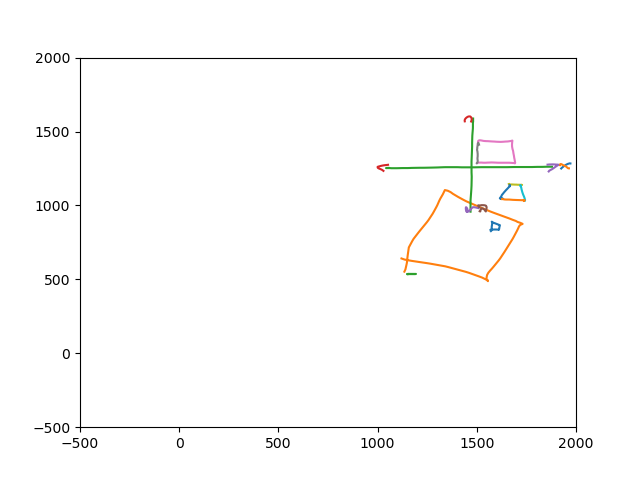

Before [ 1.21320105 -1.28276742  1.59388399 -0.45099983 -0.21058354  0.45765558
  2.83801579]
0.282916179836875
After [-3.43234205e-01  3.62915657e-01 -1.54770866e+00  0.00000000e+00
 -2.10583538e-01  1.61324004e+03  7.94488511e+02]
Before [ 0.90333372 -1.15448368  1.44369197  0.21080658 -0.19171205  1.0926646
  2.54594398]
3.496494539700052
After [-3.15850143e+00  4.03664587e+00 -1.69790068e+00  0.00000000e+00
 -1.91712052e-01  1.13935256e+03  5.15456931e+02]
Before [ 0.03879726 -1.36005318  1.57691169 -0.37473258 -0.28832579  0.16244707
  2.82636786]
0.23872380739739463
After [-9.26182946e-03  3.24677074e-01 -1.56468097e+00  0.00000000e+00
 -2.88325787e-01  1.20042668e+03  5.03503969e+02]
Before [1000. 1000.    0.    0.    0.    0.    0.]
3679.763689398729
After [3.67976369e+06 3.67976369e+06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.19400000e+03 8.28000000e+02]
Before [1000. 1000.    0.    0.    0.    0.    0.]
196.92982960824438
After [196929.82960824 196929.82960824      0. 

In [152]:
# generate the video based on the final params
anim = SketchAnimation(org_sketch, tar_sketch)
anim.seq_animate_all(final_params, save=False, denormalize_trans=True)

In [188]:
# 2, 4, 5
a, b = 2, 5
org_obj, tar_obj = org_sketch[a].get_copy(), tar_sketch[b].get_copy()
t = RegistrationUtils.obtain_transformation_matrix(trans_params[a][b])
t_denormalized = ObjectUtil.denormalized_transformation(org_obj, tar_obj, t)
org_obj.transform(t_denormalized, object_min_origin=True)
print("loss: ", losses[a][b])

5.0927311555094645
loss:  1.2334296975316525


In [189]:
tot = 0
for p1 in org_obj.get_points():
    mn = 1e9
    for p2 in tar_obj.get_points():
        mn = min(mn, Point.euclidean_distance(p1, p2))
    tot += mn

for p1 in tar_obj.get_points():
    mn = 1e9
    for p2 in org_obj.get_points():
        mn = min(mn, Point.euclidean_distance(p1, p2))
    tot += mn
print(tot)

2716.4436063905687


<IPython.core.display.Javascript object>


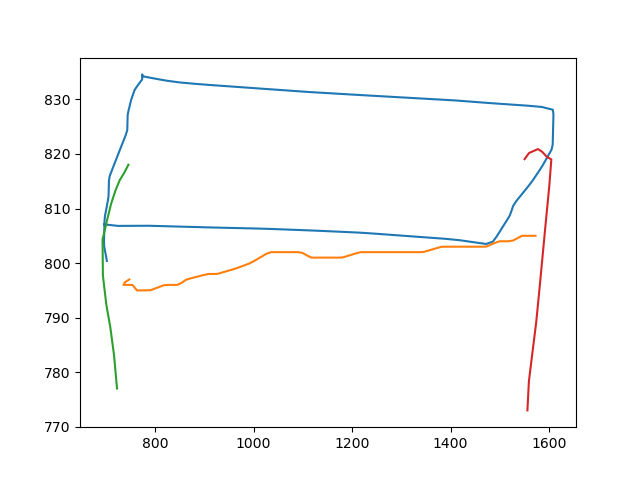

In [190]:
fig2, ax2 = plt.subplots()
org_obj.visualize(show=False, ax=ax2)
tar_obj.visualize(show=False, ax=ax2)

<IPython.core.display.Javascript object>


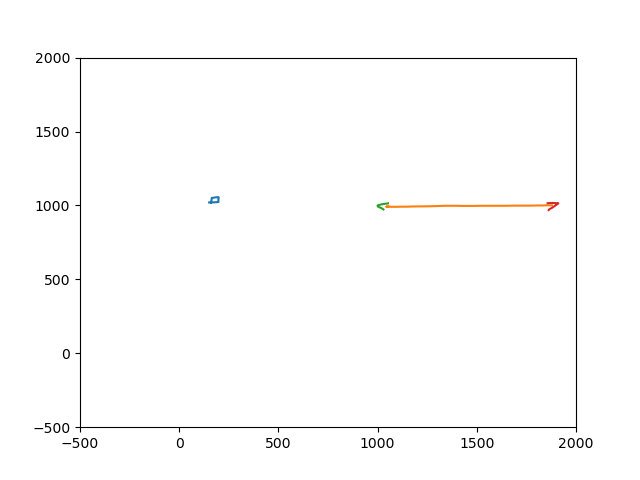

Before [ 0.03879726 -1.36005318  1.57691169 -0.37473258 -0.28832579  0.16244707
  2.82636786]
21.302220765296457
After [-8.26467783e-01  2.89721531e+01 -1.56468097e+00  0.00000000e+00
 -2.88325787e-01  1.00147987e+03  1.25558163e+03]
Seq Params: [[[-0.8264677833520839, 0.0, 0.0, 0.0, 28.97215312801496, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, -0.28832578659057606, 1.0, 0.0], [0.006115322939447301, 0.9999813012378512, 0.0, -0.9999813012378512, 0.006115322939447301, 0.0], [1.0, 0.0, 1001.4798749268742, 0.0, 1.0, 1255.581633779111]]]
1 1000


In [178]:
org_obj.reset()
obj1_seq = org_obj.get_copy()
animation = SketchAnimation([obj1_seq], [tar_obj]) 
animation.seq_animate_all([p1], 
                         denormalize_trans=True,
                         save=False) 

<IPython.core.display.Javascript object>


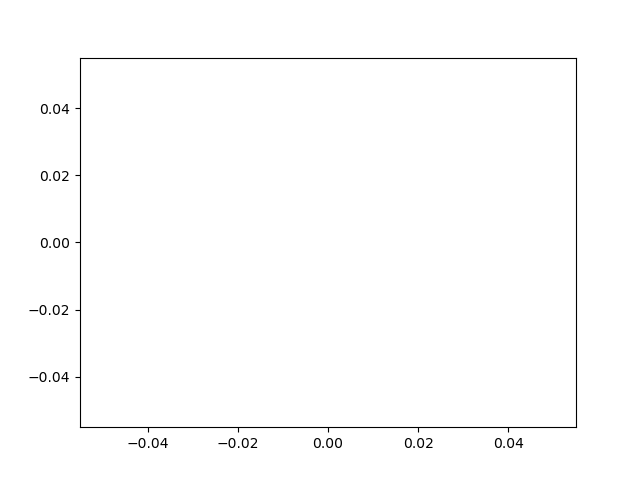

Before [[-0.9950072  -1.3808975   3.2823677   0.128263   -0.13337487  4.4090285
   3.298075  ]
 [-0.93046606 -0.8079709   2.8659897  -0.15375248  0.2023539   4.232726
   3.2444286 ]
 [-1.0449694  -1.0676048   3.249899    0.02155772 -0.16601336  3.8776245
   2.9820473 ]
 [-0.9950072  -1.3808975   3.2823677   0.128263   -0.13337487  4.4090285
   3.298075  ]
 [-1.0055671  -0.8034753   3.0768232  -0.12518194 -0.00643789  3.8698826
   2.936216  ]
 [-1.0449694  -1.0676048   3.249899    0.02155772 -0.16601336  3.8776245
   2.9820473 ]]


ValueError: setting an array element with a sequence.

In [30]:
c = 2
org_obj, tar_obj = org_sketch[c].get_copy(), tar_sketch[c].get_copy()
animation = SketchAnimation([org_obj], [tar_obj]) 
animation.seq_animate_all([trans_params[c]], 
                         denormalize_trans=True,
                         save=False) 

In [12]:
        
# fix and object in the target objects
cnt_ind = self.get_widest_obj_ind(tar_sketch)

# normalize all transformation according to the transformation of the fixed object
for i in range(len(final_params)):
    final_params[i][5] -= final_params[cnt_ind][5]
    final_params[i][6] -= final_params[cnt_ind][6]

if self.config.verbose > 3:
    model_visualizer.visualize_model(self.alignment_model, org_sketch, tar_sketch, org_sketch, tar_sketch, self.alignment_model.model_config)


if self.config.vis_video:
    # generate the video based on the final params
    anim = SketchAnimation(org_sketch, tar_sketch)
    anim.seq_animate_all(final_params, save=True, file=self.config.save_video_path, denormalize_trans=True)

NameError: name 'self' is not defined